## Imports

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn import tree
from pickle import dump
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from utils import get_classifier_metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

## PASO 1: Cargamos nuestros datos

### Random Forest

In [5]:
with open("best_model_bundle.pkl", "rb") as f:
    loaded_bundle = pickle.load(f)

# Recuperar cada elemento
loaded_model = loaded_bundle["model"]
X_train = loaded_bundle["X_train"]
X_test = loaded_bundle["X_test"]
y_train = loaded_bundle["y_train"]
y_test = loaded_bundle["y_test"]


In [6]:
y_pred = loaded_model.predict(X_test)

## PASO 2: Modelado


### Modelado

In [7]:
xgb = XGBClassifier(n_estimators=200,
                    learning_rate=0.1,
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='mlogloss')
ada = AdaBoostClassifier(n_estimators=200,
                         learning_rate=0.1,
                         random_state=42)
gb = GradientBoostingClassifier(n_estimators=200,
                                learning_rate=0.1,
                                random_state=42)
lgb = LGBMClassifier(n_estimators=200,
                     learning_rate=0.1,
                     random_state=42)


### Entrenamiento

In [8]:
ada.fit(X_train, y_train)

,estimator,None
,n_estimators,200
,learning_rate,0.1
,algorithm,'deprecated'
,random_state,42


In [9]:
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [10]:
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [11]:
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## PASO 3: Prediccion

In [12]:
ada_y_pred_test = ada.predict(X_test)
gb_y_pred_test = gb.predict(X_test)
xgb_y_pred_test =  xgb.predict(X_test)
lgb_y_pred_test = lgb.predict(X_test)

ada_y_pred_train = ada.predict(X_train)
gb_y_pred_train = gb.predict(X_train)
xbg_y_pred_train = xgb.predict(X_train)
lgb_y_pred_train = lgb.predict(X_train)

In [21]:
preds_train = {
    'AdaBoost': ada_y_pred_train,
    'Gradient Boosting': gb_y_pred_train,
    'XGBoost': xbg_y_pred_train,
    'LightGBM': lgb_y_pred_train
}

preds_test = {
    'AdaBoost': ada_y_pred_test,
    'Gradient Boosting': gb_y_pred_test,
    'XGBoost': xgb_y_pred_test,
    'LightGBM': lgb_y_pred_test
}

In [25]:
def build_metrics_df(y_true, preds_dict):
    metrics = {}
    for name, y_pred in preds_dict.items():
        acc = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        # Tomamos la clase positiva '1' (spam)
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1 = report['1']['f1-score']
        metrics[name] = [acc, precision, recall, f1]
    df = pd.DataFrame(metrics, index=['Accuracy', 'Precision', 'Recall', 'F1-score'])
    return df

In [26]:
df_train_metrics = build_metrics_df(y_train, preds_train)
df_test_metrics = build_metrics_df(y_test, preds_test)

In [27]:
df_metrics = pd.concat([df_train_metrics, df_test_metrics], keys=['Train', 'Test'])
df_metrics

AdaBoost  Gradient Boosting   XGBoost  LightGBM
Train Accuracy   0.783388           0.983713  1.000000  1.000000
      Precision  0.743902           0.995122  1.000000  1.000000
      Recall     0.572770           0.957746  1.000000  1.000000
      F1-score   0.647215           0.976077  1.000000  1.000000
Test  Accuracy   0.759740           0.733766  0.720779  0.701299
      Precision  0.680000           0.612903  0.596774  0.569231
      Recall     0.618182           0.690909  0.672727  0.672727
      F1-score   0.647619           0.649573  0.632479  0.616667

## PASO 4: Comparacion

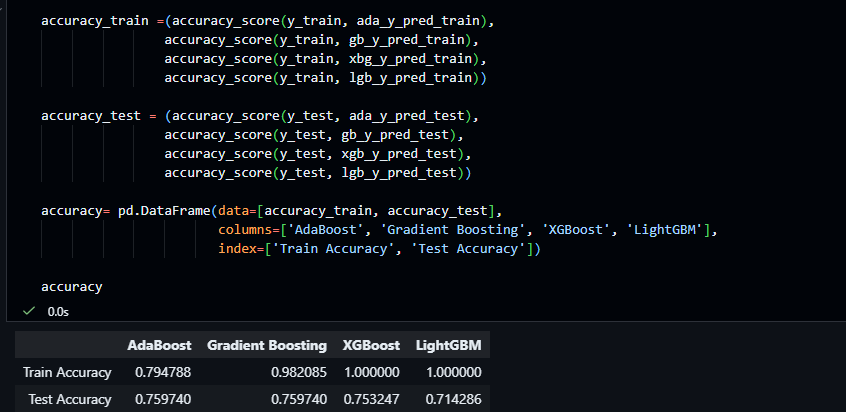

### Random Forest

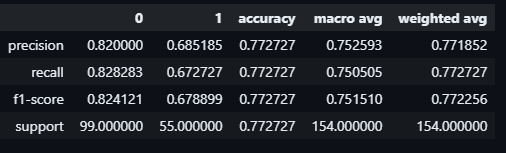
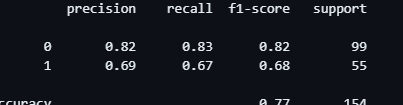
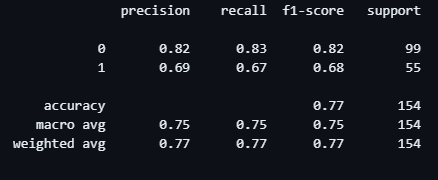
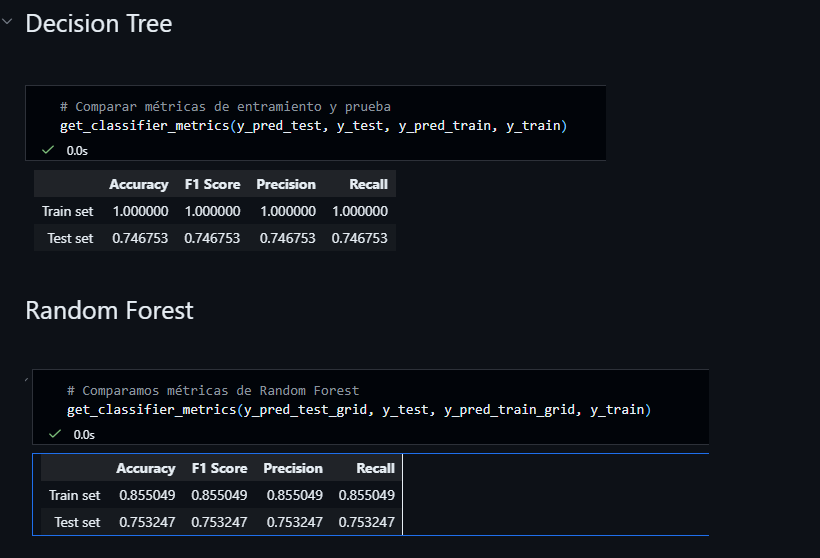

## Grafico de impacto

Grafico de impacto con Ada

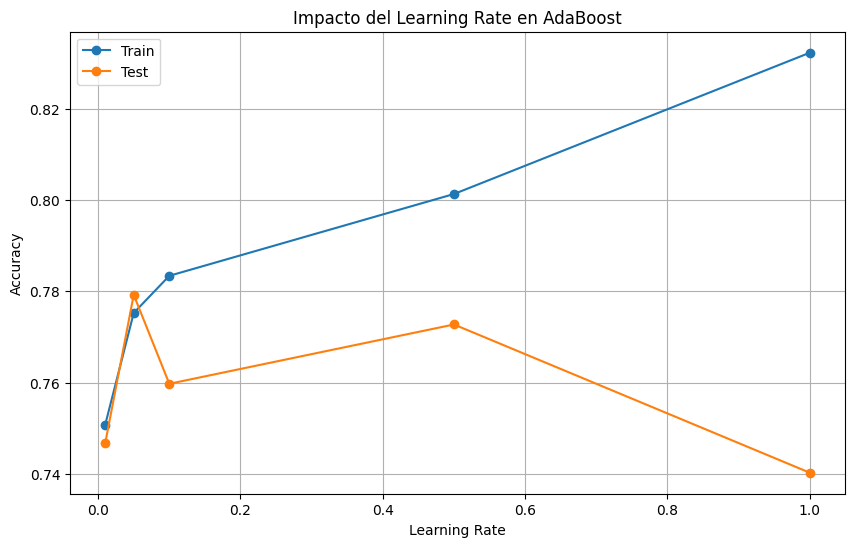

In [ ]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
train_scores = []
test_scores = []

for lr in learning_rates:
    model = AdaBoostClassifier(n_estimators=200, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_scores, marker='o', label='Train')
plt.plot(learning_rates, test_scores, marker='o', label='Test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Impacto del Learning Rate en AdaBoost')
plt.legend()
plt.grid(True)
plt.show()

Grafico de impacto con GradientBoosting

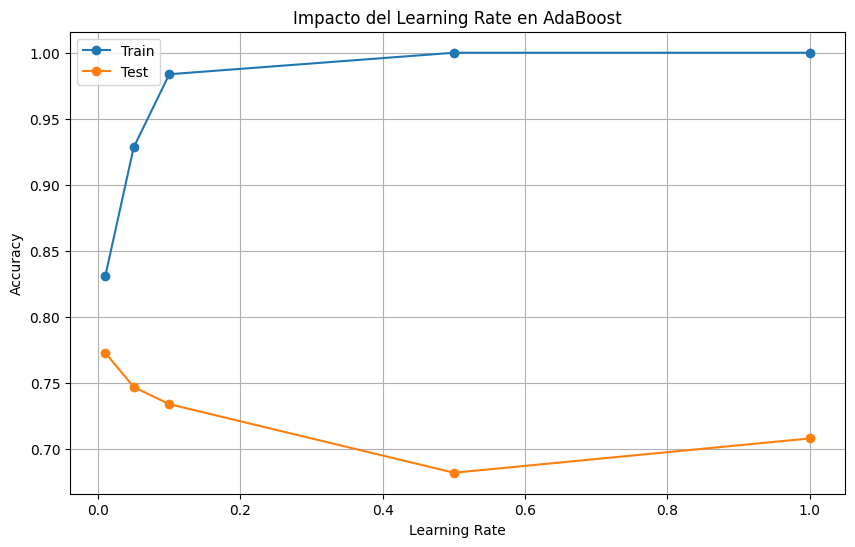

In [ ]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
train_scores = []
test_scores = []

for lr in learning_rates:
    model = GradientBoostingClassifier(n_estimators=200, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_scores, marker='o', label='Train')
plt.plot(learning_rates, test_scores, marker='o', label='Test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Impacto del Learning Rate en AdaBoost')
plt.legend()
plt.grid(True)
plt.show()

Grafico de impacto con XGBClassifier

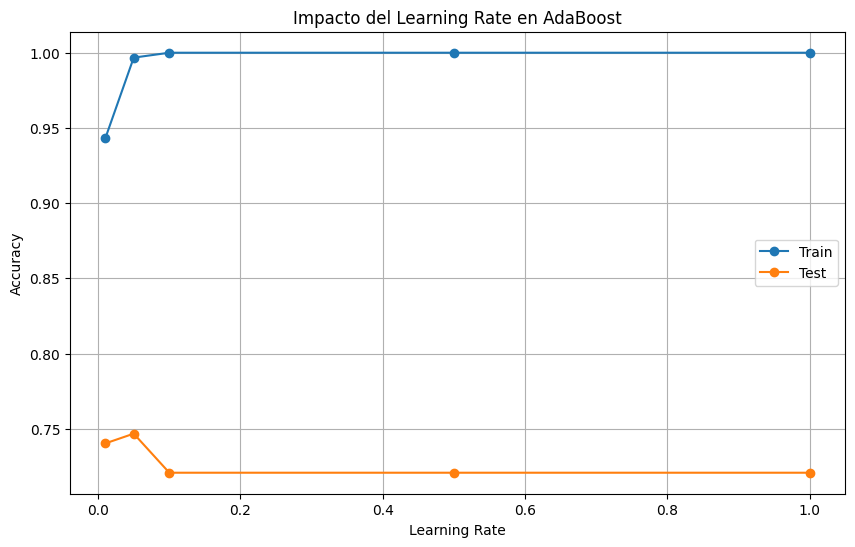

In [ ]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
train_scores = []
test_scores = []

for lr in learning_rates:
    model = XGBClassifier(n_estimators=200, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_scores, marker='o', label='Train')
plt.plot(learning_rates, test_scores, marker='o', label='Test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Impacto del Learning Rate en AdaBoost')
plt.legend()
plt.grid(True)
plt.show()

Grafico de impacto con LGBM

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

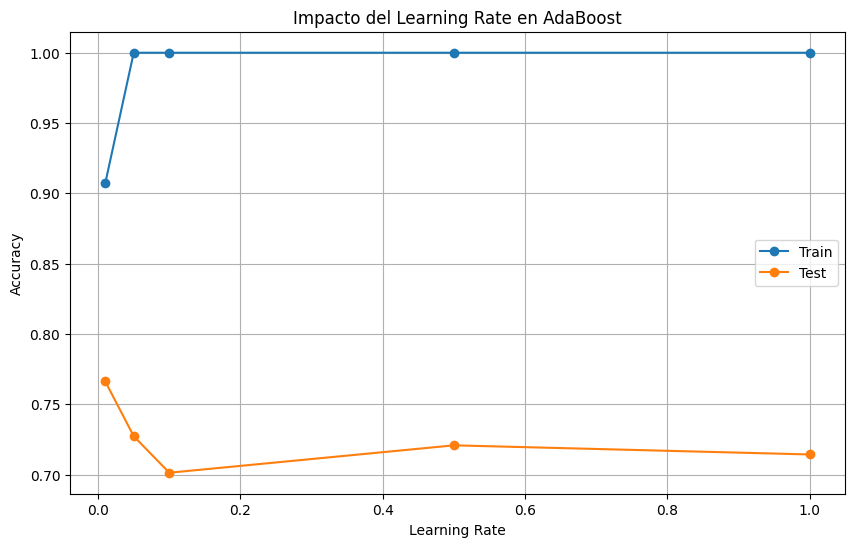

In [19]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
train_scores = []
test_scores = []

for lr in learning_rates:
    model = LGBMClassifier(n_estimators=200, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_scores, marker='o', label='Train')
plt.plot(learning_rates, test_scores, marker='o', label='Test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Impacto del Learning Rate en AdaBoost')
plt.legend()
plt.grid(True)
plt.show()

## Matriz de confusion

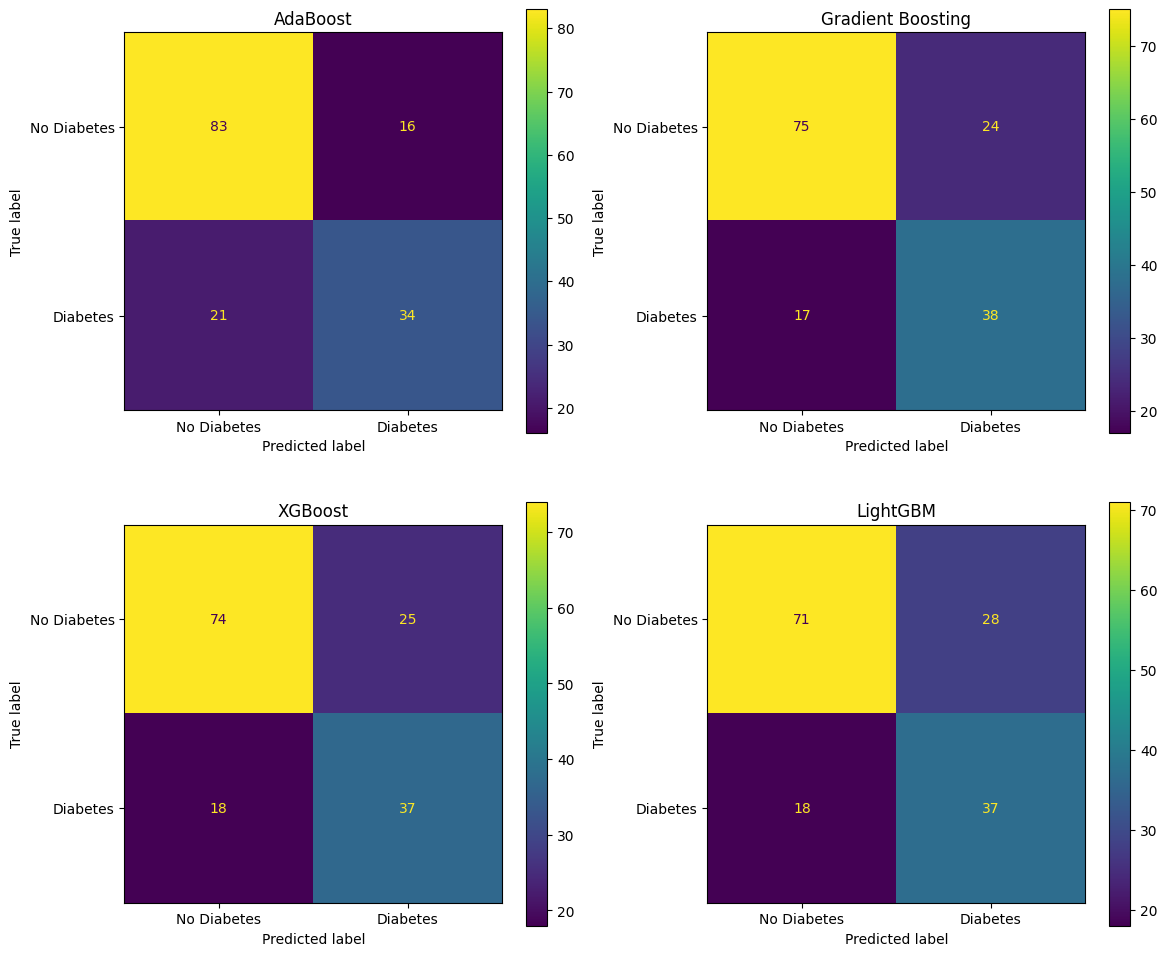

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

modelos_pred = [
    (ada, ada_y_pred_test, "AdaBoost"),
    (gb, gb_y_pred_test, "Gradient Boosting"),
    (xgb, xgb_y_pred_test, "XGBoost"),
    (lgb, lgb_y_pred_test, "LightGBM")
]

for ax, (model, y_pred, name) in zip(axes.flat, modelos_pred):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, display_labels=['No Diabetes', 'Diabetes'])
    ax.set_title(name)

plt.tight_layout()
plt.show()

## Conclusión

Podemos observar que:

1. **Decision Tree:**

 - Obtenemos valores perfectos en el Train set, esto se puede dar debido a que hay que mejorar el EDA o a que nuestra data es muy pequeña y no tenemos errores a la hora de entrenar el modelo, por otra parte, en el Test obtenemos valores más realistas obteniendo un 74% de efectividad.

2. **Random Forest:**

- Tiene un rendimiento equilibrado, pero sufre en la clase minoritaria. Cuenta con una precision del 82% para la clase 0 y un 67% para la clase 1. 
- Accuracy global: 0.7727 es competitivo, pero no sobresaliente.


3. **Boosting:**

 - Aqui podemos observar que tenemos valores variantes, esto se puede dar debido a que en nuestro EDA tenemos una data pequeña o que hace falta un analisis más profundo para mejorar nuestros datos de entrenamiento ya que, nos esta dando en el modelo XGBoost un 100% de efectividad y de igual forma en el LightBoost, lo cúal esta mal ya que no puede ser de 100% esta efectividad, ya que tenemos un claro overfitting. Por otro lado conseguimos un 79% en el AdaBoost y un 98% en GradientBoost aún así debemos tener cuidado con este porcentaje en el GradientBoost ya que puede tener un overfitting.
- A su vez tenemos unos resultados creibles en nuestros datos de Test ya que obtenemos un 75% en la mayoria de los modelados exeptuando el LightBoost donde obtenemos un 71%.

## Gurdamos el modelo

In [15]:
with open("../models/06-boosting_diabetes_model.pkl", "wb") as f:
    pickle.dump(ada, f)  # O el modelo que consideres mejor